MIT License

Copyright (c) 2023 Jacques Le Thuaut

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv

load_dotenv('.env')


True

In [3]:
import os
import json
import boto3
import logging

from IPython.core.getipython import get_ipython
from quantum_lib.s3_manager import S3Manager
from quantum_lib.iam_manager import IAMManager
from quantum_lib.quantum_circuit_manager import QuantumCircuitManager


In [4]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [5]:
def notebook_path():
    """Returns the absolute path of the notebook."""
    shell = get_ipython()
    notebook_path = os.path.join(os.getcwd(), shell.notebook_name)
    return notebook_path

In [6]:
with open('config/config.json', 'r') as f:
    config = json.load(f)
        
    s3_manager = S3Manager(config)
    iam_manager = IAMManager(config)
    quantum_manager = QuantumCircuitManager(config)
    
    s3_manager.create_bucket_if_not_exists()
    iam_manager.create_roles()
    
    file_path = "lambda/lambda_function.py"
    script_dir = %pwd
    lambda_file_path = os.path.join(script_dir, file_path)
    iam_manager.create_lambda_function(lambda_file_path)

    circuit = quantum_manager.create_basic_circuit()
    quantum_manager.apply_gates(circuit, target_qubit=0, entangle=True)

    task_arn = quantum_manager.run_circuit(circuit)
    print(f"Task ARN: {task_arn}")

    results = quantum_manager.get_results()
    print(f"Results: {results}")
    
    s3_manager.save_to_s3(results, "results-key")

    # Perform any cleanup, if necessary
    #s3_manager.cleanup()
    #iam_manager.cleanup()
    #iam_manager.delete_lambda_function()
    #iam_manager.delete_roles()



Role BraketRole already exists.
Role S3Role already exists.
Role LambdaRole already exists.
Function YourLambdaFunctionName already exists. Updating the function code.
Task ARN: arn:aws:braket:eu-west-2:690026366446:quantum-task/6fef534e-af92-4e55-9f1a-264506d1c3f9
Results: Counter({'00': 482, '11': 256, '10': 177, '01': 85})


## Estimated probability distribution of a 2-qubit system


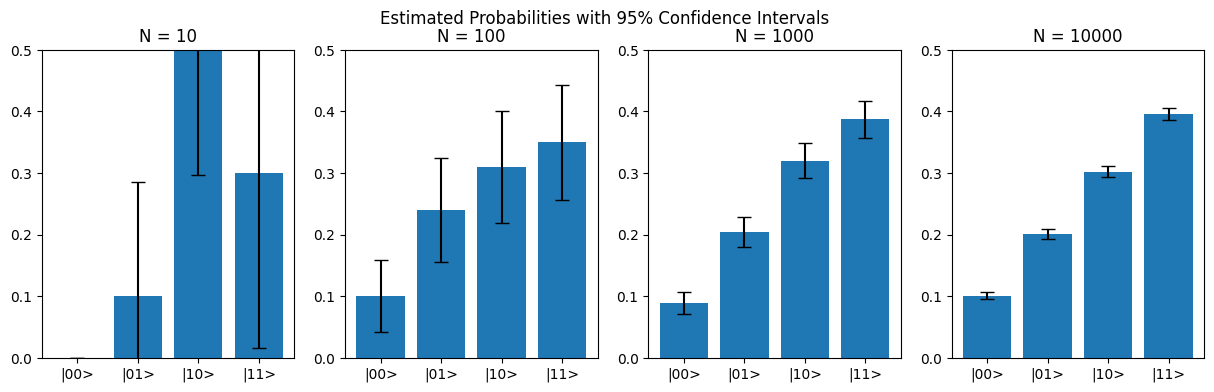

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define a hypothetical probability distribution for a 2-qubit system
# This is the theoretical distribution you would get with infinite shots
p = np.array([0.1, 0.2, 0.3, 0.4])  # Probabilities for states |00>, |01>, |10>, and |11>

# Function to simulate N shots
def simulate_shots(prob_dist, N):
    return np.random.multinomial(N, prob_dist)

# Simulate for different numbers of shots
N_values = [10, 100, 1000, 10000]
simulated_results = [simulate_shots(p, N) for N in N_values]

# Calculate the estimated probabilities and standard errors
estimated_p = [results / N for results, N in zip(simulated_results, N_values)]
standard_errors = [np.sqrt((est * (1 - est)) / N) for est, N in zip(estimated_p, N_values)]

# Plot the results
fig, axes = plt.subplots(1, len(N_values), figsize=(15, 4))

for i, N in enumerate(N_values):
    ax = axes[i]
    ax.bar(range(len(p)), estimated_p[i], yerr=standard_errors[i] * 1.96, capsize=5)
    ax.set_title(f"N = {N}")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([f"|{i:02b}>" for i in range(len(p))])
    ax.set_ylim([0, max(p) + 0.1])

plt.suptitle("Estimated Probabilities with 95% Confidence Intervals")
plt.show()

